In [ ]:
import sys
from matplotlib import pyplot
from keras.datasets import cifar10, mnist, fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.optimizers import SGD

In [ ]:
from tqdm import tqdm
import random
random.seed(1485)
import numpy as np
import tensorflow as tf

In [ ]:
def load_dataset(name):
  if name == "mnist":
    (trainX, trainY), (testX, testY) = mnist.load_data() #cifar10.load_data()
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
  elif name == "cifar":
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
  elif name == "fashion":
    (trainX, trainY), (testX, testY) = fashion_mnist.load_data()
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
  return trainX, trainY, testX, testY

def prep_pixels(train, test):
  train_norm = train.astype('float32')
  test_norm = test.astype('float32')
  train_norm = train_norm / 255.0
  test_norm = test_norm / 255.0
  return train_norm, test_norm

In [ ]:
# CIFAR
def vgg_custom_model(lr, mom):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))

  opt = SGD(lr=lr, momentum=mom)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
# MNIST (28,28,1)
def vgg_custom_model(lr, mom):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(28, 28, 1)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  # model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  # model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  # model.add(MaxPooling2D((2, 2)))
  # model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  # model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  # model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))

  opt = SGD(lr=lr, momentum=mom)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
trainX, trainY, testX, testY = load_dataset("mnist")
trainX, testX = prep_pixels(trainX, testX)

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
model = vgg_custom_model(lr=0.0001, mom=0.9)
history = model.fit(trainX, trainY, epochs=1, batch_size=64, validation_data=(testX, testY), verbose=1)

938/938 [==============================] - 119s 126ms/step - loss: 0.1539 - accuracy: 0.9531 - val_loss: 0.0558 - val_accuracy: 0.9815


In [ ]:
loss, acc = model.evaluate(testX, testY, verbose=1)
print(acc)

313/313 [==============================] - 10s 31ms/step - loss: 0.0558 - accuracy: 0.9815
0.9815000295639038


## Pre processed input

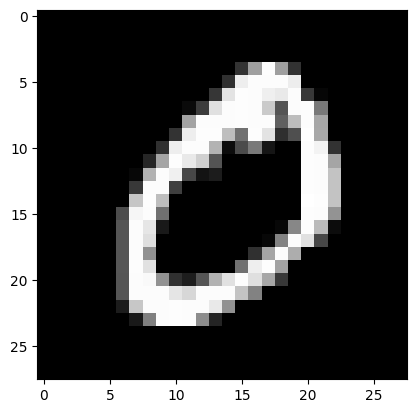

In [ ]:
pyplot.imshow(trainX[1], cmap='gray')
# trainX[1]

In [ ]:
import numpy as np
import tensorflow as tf
greyscale_threshold = 0.2  # white is 1 ; 0.2 for mnist, 0.5 for cifar

def get_flip_contrast(converted_img):
    # guesstimate if image has dark or light background
    grey_qty = 0
    for i in converted_img:
        grey_qty += ((i > greyscale_threshold).sum()/len(i))
    grey_qty_normalized = grey_qty/converted_img.shape[0]
#     print(grey_qty_normalized)
    if grey_qty_normalized >= 0.5:
        # image is light on dark background => do not flip contrast
        return 0
    else:
        # image is dark on light background => flip contrast
        return 1

def binarize_image(converted_img):
    # we want to avoid background but this should be reversed for dark image on light background
    flip_contrast = get_flip_contrast(converted_img)
    binarized = []
    for i in converted_img:
        # if flip_contrast:
        #     binarized_row = np.ones(len(i))
        #     for j_ind, j in enumerate(i):
        #         if j>=greyscale_threshold:
        #             binarized_row[j_ind] = 0
        # else:
        binarized_row = np.zeros(len(i))
        for j_ind, j in enumerate(i):
            if j>=greyscale_threshold:
                binarized_row[j_ind] = 1
        binarized.append(binarized_row)

    binarized = np.array(binarized)
    return binarized

In [ ]:
im=0
print(trainX.shape)
print(trainX[im].shape)
print(get_flip_contrast(trainX[im]))
# b = binarize_image(trainX[im])
# c = np.reshape(b, (-1, 4))
# print(c.shape)
for im in range(5):
    b = tf.image.rgb_to_grayscale(trainX[im])
    b = binarize_image(b.numpy())
    # c = np.reshape(b, (-1, 4))
    c = np.expand_dims(b, axis=2)
    print(c.shape)
pyplot.imshow(c, cmap='gray')

(60000, 28, 28, 1)
(28, 28, 1)
1


InvalidArgumentError: {{function_node __wrapped__MatMul_device_/job:localhost/replica:0/task:0/device:CPU:0}} Matrix size-incompatible: In[0]: [784,1], In[1]: [3,1] [Op:MatMul] name: 

In [ ]:
pY= np.asarray(processed_testX)
print(pY.shape)

(10000, 32, 32, 1)


In [ ]:
#all together NOT reqd
processed_trainX=[]
for im in tqdm(range(len(trainX))):
    # b = tf.image.rgb_to_grayscale(trainX[im])
    # b = binarize_image(b.numpy())
    b = trainX[im]
    b = binarize_image(b)
    c = np.reshape(b, (-1, 4))
    # c = np.expand_dims(b, axis=2)
    processed_trainX.append(c)


100%|██████████| 60000/60000 [01:37<00:00, 614.80it/s]


In [ ]:
#all together NOT reqd
processed_testX=[]
for im in tqdm(range(len(testX))):
    # b = tf.image.rgb_to_grayscale(testX[im])
    # b = binarize_image(b.numpy())
    b = testX[im]
    b = binarize_image(b)
    c = np.reshape(b, (-1, 4))
    # c = np.expand_dims(b, axis=2)
    processed_testX.append(c)


100%|██████████| 10000/10000 [00:14<00:00, 686.83it/s]


### N-bit reservoir data

In [ ]:
!unzip nbit_analysis_for_reservoir.zip

Archive:  nbit_analysis_for_reservoir.zip
 extracting: Extracted/4-bit.xlsx    
 extracting: Extracted/4-bit_entropy.xlsx  
 extracting: Extracted/5-bit.xlsx    
 extracting: Extracted/5-bit_entropy.xlsx  
 extracting: Extracted/6-bit.xlsx    
 extracting: Extracted/6-bit_entropy.xlsx  
 extracting: Extracted/7-bit.xlsx    
 extracting: Extracted/7-bit_entropy.xlsx  
 extracting: Extracted/8-bit.xlsx    
 extracting: Extracted/8-bit_entropy.xlsx  


In [ ]:
import pandas as pd
readout_mapping = pd.read_excel('Extracted/4-bit.xlsx')
readout_mapping.head()

,Unnamed: 0,0.3,0.4,0.5,0.6,0.7
0,1,20.385,43.923,61.779,77.105,90.162
1,2,18.694,35.285,49.405,61.161,71.154
2,3,52.554,82.902,105.034,120.577,130.879
3,4,16.016,29.244,40.702,50.776,58.739
4,5,41.516,71.200,94.731,112.138,125.132


In [ ]:
readout_mapping[0.3]

0     20.385
1     18.694
2     52.554
3     16.016
4     41.516
5     42.890
6     73.044
7     13.670
8     39.264
9     34.485
10    65.988
11    35.852
12    59.483
13    60.071
14    87.563
Name: 0.3, dtype: float64

In [ ]:
config = "4bit40p"
vout = list(readout_mapping[0.4])
vout_mapping = {}
vout_mapping['{0:04b}'.format(0)] = 0.000
for v_ind, v in enumerate(vout, 1):
    vout_mapping['{0:04b}'.format(v_ind)] = v
print(vout_mapping)

{'0000': 0.0, '0001': 43.922999999999995, '0010': 35.285, '0011': 82.902, '0100': 29.244, '0101': 71.2, '0110': 66.667, '0111': 105.765, '1000': 24.908, '1001': 68.086, '1010': 58.504, '1011': 100.45400000000001, '1100': 55.891000000000005, '1101': 93.439, '1110': 86.708, '1111': 120.542}


### Reservoir Vouts

In [ ]:
import pandas as pd
readout_mapping = pd.read_excel('Vout.xlsx')
readout_mapping.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,60.8684,41.5629,86.3955,34.2662,83.8812,64.1904,99.4241,29.4246,79.9931,61.3460,98.9802,53.3931,97.0847,78.0642,111.704
1,0,61.1562,41.7318,85.0438,34.2150,82.4636,62.8211,98.8232,29.6049,79.2128,61.3729,98.1410,53.5749,96.0234,77.4053,110.492
2,0,60.4900,41.8793,85.8486,33.9915,82.3169,62.9551,99.1851,29.7845,81.0870,61.7485,97.1178,53.2268,95.5435,76.3657,109.809
3,0,60.8307,41.7019,84.6410,34.0208,82.8960,62.7907,98.6990,29.5571,80.3683,61.1568,98.1737,53.6685,96.0785,76.7872,109.196
4,0,60.7626,42.0426,84.5182,34.2287,82.9573,62.9176,100.2519,29.2494,79.0557,61.0597,97.4431,53.4340,96.3310,77.5604,111.181


In [ ]:
vout = list(readout_mapping.mean(axis=0))
vout_mapping = {}
for v_ind, v in enumerate(vout):
    vout_mapping['{0:04b}'.format(v_ind)] = v
print(vout_mapping)

{'0000': 0.0, '0001': 60.946725, '0010': 41.91007499999999, '0011': 84.99817999999999, '0100': 34.22956, '0101': 81.90558, '0110': 62.871390000000005, '0111': 99.07972, '1000': 29.628125000000004, '1001': 80.17856500000002, '1010': 61.29259, '1011': 98.35782999999999, '1100': 53.645735, '1101': 95.66469499999998, '1110': 77.352185, '1111': 110.78180000000002}


### Using Vout mapping

In [ ]:
from tqdm import tqdm
processed_trainX=[]
for im in tqdm(range(len(trainX))):
    # b = tf.image.rgb_to_grayscale(trainX[im])
    # b = binarize_image(b.numpy())
    b = trainX[im]
    b = binarize_image(b)
    c = np.reshape(b, (-1, 4))
    im_res_inp = []
    for i in c:
        bit_pattern = ''.join([str(int(i[j])) for j in range(4)])
        im_res_inp.append(vout_mapping[bit_pattern])
    # processed_trainX.append(im_res_inp)
    d=np.reshape(im_res_inp, (-1, 14))
    processed_trainX.append(d)
pX= np.asarray(processed_trainX)


100%|██████████| 60000/60000 [02:33<00:00, 390.82it/s]


In [ ]:
processed_testX=[]
for im in tqdm(range(len(testX))):
    # b = tf.image.rgb_to_grayscale(testX[im])
    # b = binarize_image(b.numpy())
    b = testX[im]
    b = binarize_image(b)
    c = np.reshape(b, (-1, 4))
    im_res_inp = []
    for i in c:
        bit_pattern = ''.join([str(int(i[j])) for j in range(4)])
        im_res_inp.append(vout_mapping[bit_pattern])
    # processed_trainX.append(im_res_inp)
    d=np.reshape(im_res_inp, (-1, 14))
    processed_testX.append(d)
pY= np.asarray(processed_testX)


100%|██████████| 10000/10000 [00:28<00:00, 350.71it/s]


In [ ]:
def vgg_custom_model(lr, mom):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(14, 14, 1)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  # model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  # model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  # model.add(MaxPooling2D((2, 2)))
  # model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  # model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  # model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))

  opt = SGD(lr=lr, momentum=mom)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model


In [ ]:
model = vgg_custom_model(0.001,0.9)
history = model.fit(pX, trainY, epochs=20, batch_size=32, validation_data=(pY, testY), verbose=1)

Epoch 1/20
1875/1875 [==============================] - 41s 22ms/step - loss: 5701558884892672.0000 - accuracy: 0.1105 - val_loss: 2.3013 - val_accuracy: 0.1135
Epoch 2/20
1875/1875 [==============================] - 38s 20ms/step - loss: 2.3018 - accuracy: 0.1120 - val_loss: 2.3020 - val_accuracy: 0.1028
Epoch 3/20
1875/1875 [==============================] - 38s 20ms/step - loss: 2.3018 - accuracy: 0.1123 - val_loss: 2.3023 - val_accuracy: 0.1028
Epoch 4/20
1875/1875 [==============================] - 40s 21ms/step - loss: 2.3019 - accuracy: 0.1107 - val_loss: 2.3013 - val_accuracy: 0.1135
Epoch 5/20
1875/1875 [==============================] - 40s 21ms/step - loss: 2.3019 - accuracy: 0.1114 - val_loss: 2.3019 - val_accuracy: 0.1135
Epoch 6/20
1875/1875 [==============================] - 38s 20ms/step - loss: 2.3019 - accuracy: 0.1111 - val_loss: 2.3015 - val_accuracy: 0.1135
Epoch 7/20
1875/1875 [==============================] - 40s 21ms/step - loss: 2.3018 - accuracy: 0.1116 - val

## Set up W&B

In [ ]:
!pip install wandb -qU
import wandb
from wandb.keras import WandbCallback
wandb.login()

True

In [ ]:
total_runs = 1
epochs = 1
for run in range(total_runs):
  wandb.init(
      project="reservoir-nn",
      name=f"experiment_{run}",
      # Track hyperparameters and run metadata
      config={
      "learning_rate": 0.001,
      "architecture": "VGG custom 3",
      "dataset": "CIFAR-10",
      "epochs": epochs,
      "optimizer": "SGD"
      })
  wandb_callback = WandbCallback(monitor='val_loss', log_weights=False, log_evaluation=True, validation_steps=1)
  callbacks = [wandb_callback]

  model.fit(trainX, trainY, epochs=epochs, batch_size=64, callbacks=callbacks, validation_data=(testX, testY), verbose=1)
  loss, acc = model.evaluate(testX, testY, verbose=1)
  wandb.log({"acc": acc, "loss": loss})
  wandb.finish()

782/782 [==============================] - ETA: 0s - loss: 1.6766 - accuracy: 0.3953

wandb: Adding directory to artifact (/content/wandb/run-20230322_021127-rz2kz74r/files/model-best)... Done. 0.0s


313/313 [==============================] - 20s 63ms/step - loss: 1.4960 - accuracy: 0.4555


acc,▁
accuracy,▁
epoch,▁
loss,█▁
val_accuracy,▁
val_loss,▁
acc,0.4555
accuracy,0.39532
best_epoch,0
best_val_loss,1.49602
epoch,0


## Experiments

In [ ]:
epochs = 20
# learning_rates = [0.001, 0.001, 0.005, 0.01]
# momentums = [0.9, 0.5, 0.9, 0.9]
learning_rates = [0.001, 0.0001]
momentums = [0.9, 0.9]
total_runs = len(learning_rates)
params = list(zip(learning_rates, momentums))
for run in range(total_runs):
  lr, mom = params[run]
  wandb.init(
      project="reservoir-nn",
      name=f"experiment_readout_{run}",
      # Track hyperparameters and run metadata
      config={
      "architecture": "VGG custom 1",
      "dataset": "MNIST binarized 14x14",
      "epochs": epochs,
      "optimizer": "SGD",
      "learning_rate": lr,
      "momentum": mom
      })
  wandb_callback = WandbCallback(monitor='val_loss', log_weights=False, log_evaluation=True, validation_steps=1)
  callbacks = [wandb_callback]

  model = vgg_custom_model(lr, mom)
  model.fit(pX, trainY, epochs=epochs, batch_size=64, callbacks=callbacks, validation_data=(pY, testY), verbose=1)
  loss, acc = model.evaluate(pY, testY, verbose=1)
  wandb.log({"acc": acc, "loss": loss})
  wandb.finish()

Problem at: <ipython-input-28-8c65b052b37b> 10 <cell line: 8>


CommError: ignored

MNIST numbrs

In [ ]:
model = vgg_custom_model(0.001,0.9)
history = model.fit(pX, trainY, epochs=20, batch_size=32, validation_data=(pY, testY), verbose=1)

Epoch 1/20
1875/1875 [==============================] - 10s 5ms/step - loss: 2.7249 - accuracy: 0.1773 - val_loss: 2.1234 - val_accuracy: 0.1834
Epoch 2/20
1875/1875 [==============================] - 8s 4ms/step - loss: 2.1169 - accuracy: 0.1825 - val_loss: 2.1210 - val_accuracy: 0.1796
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 2.1151 - accuracy: 0.1827 - val_loss: 2.1179 - val_accuracy: 0.1833
Epoch 4/20
1875/1875 [==============================] - 6s 3ms/step - loss: 2.1138 - accuracy: 0.1831 - val_loss: 2.1183 - val_accuracy: 0.1831
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - loss: 1.7796 - accuracy: 0.3287 - val_loss: 0.5374 - val_accuracy: 0.8313
Epoch 6/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2848 - accuracy: 0.9114 - val_loss: 0.1905 - val_accuracy: 0.9367
Epoch 7/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1817 - accuracy: 0.9429 - val_loss: 0.1440 - val_accuracy

In [ ]:
model = vgg_custom_model(0.0001,0.9)
history = model.fit(pX, trainY, epochs=20, batch_size=32, validation_data=(pY, testY), verbose=1)

Epoch 1/20
1875/1875 [==============================] - 7s 3ms/step - loss: 0.9349 - accuracy: 0.8867 - val_loss: 0.2022 - val_accuracy: 0.9369
Epoch 2/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1764 - accuracy: 0.9456 - val_loss: 0.1719 - val_accuracy: 0.9453
Epoch 3/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1387 - accuracy: 0.9579 - val_loss: 0.1333 - val_accuracy: 0.9583
Epoch 4/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1181 - accuracy: 0.9636 - val_loss: 0.1217 - val_accuracy: 0.9625
Epoch 5/20
1875/1875 [==============================] - 7s 3ms/step - loss: 0.1045 - accuracy: 0.9670 - val_loss: 0.1101 - val_accuracy: 0.9656
Epoch 6/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0946 - accuracy: 0.9704 - val_loss: 0.1066 - val_accuracy: 0.9678
Epoch 7/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0844 - accuracy: 0.9731 - val_loss: 0.1029 - val_accuracy:

Fashion MNIST

In [ ]:
model = vgg_custom_model(0.001,0.9)
history = model.fit(pX, trainY, epochs=20, batch_size=32, validation_data=(pY, testY), verbose=1)

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
1875/1875 [==============================] - 7s 3ms/step - loss: 3.9301 - accuracy: 0.0993 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/20
1875/1875 [==============================] - 7s 3ms/step - loss: 2.3027 - accuracy: 0.0977 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/20
1875/1875 [==============================] - 6s 3ms/step - loss: 2.3027 - accuracy: 0.0969 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 2.3027 - accuracy: 0.0982 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/20
1875/1875 [==============================] - 6s 3ms/step - loss: 2.3027 - accuracy: 0.0976 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/20
1875/1875 [==============================] - 6s 3ms/step - loss: 2.3027 - accuracy: 0.0978 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/20
1875/1875 [==============================] - 6s 3ms/step - loss: 2.3027 - accuracy: 0.0998 - val_loss: 2.3026 - val_accuracy:

In [ ]:
model = vgg_custom_model(0.0001,0.9)
history = model.fit(pX, trainY, epochs=20, batch_size=32, validation_data=(pY, testY), verbose=1)

Epoch 1/20
1875/1875 [==============================] - 7s 3ms/step - loss: 1.2087 - accuracy: 0.7731 - val_loss: 0.5397 - val_accuracy: 0.8090
Epoch 2/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4767 - accuracy: 0.8266 - val_loss: 0.4876 - val_accuracy: 0.8267
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4328 - accuracy: 0.8396 - val_loss: 0.4731 - val_accuracy: 0.8260
Epoch 4/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4073 - accuracy: 0.8481 - val_loss: 0.4633 - val_accuracy: 0.8286
Epoch 5/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3884 - accuracy: 0.8535 - val_loss: 0.4430 - val_accuracy: 0.8385
Epoch 6/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3733 - accuracy: 0.8609 - val_loss: 0.4340 - val_accuracy: 0.8422
Epoch 7/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3610 - accuracy: 0.8645 - val_loss: 0.4295 - val_accuracy:

## Study : Number of channels in data vs Accuracy

CIFAR greyscale 2^n states

In [ ]:
trainX, trainY, testX, testY = load_dataset("cifar")
trainX, testX = prep_pixels(trainX, testX)

170498071/170498071 [==============================] - 13s 0us/step


In [ ]:
import numpy as np
import tensorflow as tf
nstate = 4
one_range = 1/nstate
curr_range = one_range
greyscale_threshold = []
for i in range(nstate):
  greyscale_threshold.append(curr_range)
  curr_range += one_range
print(greyscale_threshold)

[0.25, 0.5, 0.75, 1.0]


In [ ]:
def soft_binarize_image(converted_img):
    binarized = []
    for i in converted_img:
        binarized_row = np.zeros(len(i))
        for j_ind, j in enumerate(i):
          for state, state_val in enumerate(greyscale_threshold):
            if j<=state_val:
                binarized_row[j_ind] = state
                break
        binarized.append(binarized_row)

    binarized = np.array(binarized)
    return binarized

In [ ]:
processed_trainX=[]
for im in tqdm(range(len(trainX))):
    b = tf.image.rgb_to_grayscale(trainX[im])
    b = soft_binarize_image(b.numpy())
    processed_trainX.append(b)
pX= np.asarray(processed_trainX)

processed_testX=[]
for im in tqdm(range(len(testX))):
    b = tf.image.rgb_to_grayscale(testX[im])
    b = soft_binarize_image(b.numpy())
    processed_testX.append(b)
pY= np.asarray(processed_testX)

100%|██████████| 10000/10000 [01:01<00:00, 161.33it/s]


In [ ]:
from keras.optimizers import RMSprop

def vgg_custom_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 1)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))

  #opt = SGD(lr=0.0001, momentum=0.9)
  # opt = Adagrad(learning_rate=0.0001, initial_accumulator_value=0.1, epsilon=1e-03)
  opt = RMSprop(learning_rate=0.0001, rho=0.9, momentum=0.1, epsilon=1e-03, centered=False)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
model = vgg_custom_model()
history = model.fit(pX, trainY, epochs=40, batch_size=64, validation_data=(pY, testY), verbose=1)
loss, acc = model.evaluate(pY, testY, verbose=1)
print(acc, loss)

Epoch 1/40
782/782 [==============================] - 7s 9ms/step - loss: 1.9160 - accuracy: 0.3124 - val_loss: 1.9141 - val_accuracy: 0.3019
Epoch 2/40
782/782 [==============================] - 6s 8ms/step - loss: 1.6538 - accuracy: 0.4114 - val_loss: 1.6604 - val_accuracy: 0.4000
Epoch 3/40
782/782 [==============================] - 6s 8ms/step - loss: 1.5340 - accuracy: 0.4571 - val_loss: 1.5520 - val_accuracy: 0.4527
Epoch 4/40
782/782 [==============================] - 6s 8ms/step - loss: 1.4518 - accuracy: 0.4881 - val_loss: 1.4755 - val_accuracy: 0.4825
Epoch 5/40
782/782 [==============================] - 6s 8ms/step - loss: 1.3819 - accuracy: 0.5156 - val_loss: 1.4825 - val_accuracy: 0.4850
Epoch 6/40
782/782 [==============================] - 6s 8ms/step - loss: 1.3225 - accuracy: 0.5375 - val_loss: 1.6596 - val_accuracy: 0.4352
Epoch 7/40
782/782 [==============================] - 7s 8ms/step - loss: 1.2727 - accuracy: 0.5546 - val_loss: 1.3762 - val_accuracy: 0.5180
Epoch 

KeyboardInterrupt: ignored

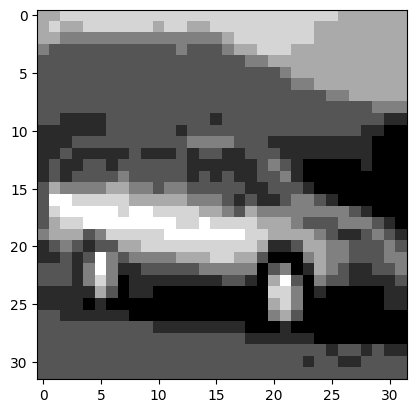

In [ ]:
pyplot.imshow(pX[4], cmap='gray')

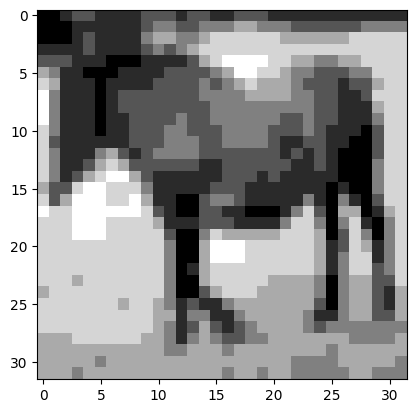

In [ ]:
pyplot.imshow(pX[7], cmap='gray')

## Feed forward NN

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 32)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])
model.compile(optimizer=SGD(lr=0.001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# history = model.fit(pX, trainY, epochs=1, batch_size=32, validation_data=(pY, testY), verbose=1)

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### MNIST pre-processing

In [ ]:
def load_dataset(name):
  if name == "mnist":
    (trainX, trainY), (testX, testY) = mnist.load_data()
    trainX = trainX.reshape((trainX.shape[0], 28 * 28 * 1))
    testX = testX.reshape((testX.shape[0], 28 * 28 * 1))
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
  return trainX, trainY, testX, testY

def prep_pixels(train, test):
  train_norm = train.astype('float32')
  test_norm = test.astype('float32')
  train_norm = train_norm / 255.0
  test_norm = test_norm / 255.0
  return train_norm, test_norm

trainX, trainY, testX, testY = load_dataset("mnist")
trainX, testX = prep_pixels(trainX, testX)

In [ ]:
greyscale_threshold = 0.2  # white is 1 ; 0.2 for mnist, 0.5 for cifar

def binarize_image(converted_img):
    binarized_row = np.zeros(len(converted_img))
    for j_ind, j in enumerate(converted_img):
        if j>=greyscale_threshold:
            binarized_row[j_ind] = 1
    binarized = np.array(binarized_row)
    return binarized

processed_trainX=[]
for im in tqdm(range(len(trainX))):
    b = trainX[im]
    b = binarize_image(b)
    c = np.reshape(b, (-1, 4))
    im_res_inp = []
    for i in c:
        bit_pattern = ''.join([str(int(i[j])) for j in range(4)])
        im_res_inp.append(vout_mapping[bit_pattern])
    processed_trainX.append(im_res_inp)
pX= np.asarray(processed_trainX)

processed_testX=[]
for im in tqdm(range(len(testX))):
    b = testX[im]
    b = binarize_image(b)
    c = np.reshape(b, (-1, 4))
    im_res_inp = []
    for i in c:
        bit_pattern = ''.join([str(int(i[j])) for j in range(4)])
        im_res_inp.append(vout_mapping[bit_pattern])
    processed_testX.append(im_res_inp)
pY= np.asarray(processed_testX)

100%|██████████| 10000/10000 [00:32<00:00, 310.35it/s]


In [ ]:
# trainX[1]
print(trainX.shape)

# pX[1]
print(pX.shape)
print(pY.shape)

(60000, 784)
(60000, 196)
(10000, 196)


1 layer FFN

In [ ]:
from keras.optimizers import Adam

# Check input shape when changing dataset
def ann_custom_model_1(lr, mom):
  model = Sequential()
  model.add(Dense(98, input_shape=(196,), activation="relu", kernel_initializer='he_normal'))
  model.add(Dense(10, activation='softmax'))

  # opt = SGD(lr=lr, momentum=mom)
  opt = Adam(lr=lr)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
model1 = ann_custom_model_1(0.001,0.9)
# history = model1.fit(trainX, trainY, epochs=20, batch_size=32, validation_data=(testX, testY), verbose=1)
history = model1.fit(pX, trainY, epochs=50, batch_size=32, validation_data=(pY, testY), verbose=1)

Epoch 1/50
1875/1875 [==============================] - 10s 5ms/step - loss: 2.1147 - accuracy: 0.8608 - val_loss: 0.6323 - val_accuracy: 0.9041
Epoch 2/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4321 - accuracy: 0.9217 - val_loss: 0.3286 - val_accuracy: 0.9292
Epoch 3/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2440 - accuracy: 0.9379 - val_loss: 0.2472 - val_accuracy: 0.9373
Epoch 4/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1886 - accuracy: 0.9467 - val_loss: 0.2505 - val_accuracy: 0.9329
Epoch 5/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1684 - accuracy: 0.9516 - val_loss: 0.1942 - val_accuracy: 0.9464
Epoch 6/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1560 - accuracy: 0.9555 - val_loss: 0.2031 - val_accuracy: 0.9476
Epoch 7/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1396 - accuracy: 0.9593 - val_loss: 0.2042 - val_accuracy

In [ ]:
def baseline_dense(lr, mom):
  model = Sequential()
  model.add(Dense(128, input_shape=(784,), activation="relu", kernel_initializer='he_uniform'))
  # model.add(Dense(10, input_shape=(196,), activation="softmax", kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))

  opt = SGD(lr=lr, momentum=mom)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
model1 = baseline_dense(0.1,0.9)
history = model1.fit(trainX, trainY, epochs=20, batch_size=32, validation_data=(testX, testY), verbose=1)
# history = model1.fit(pX, trainY, epochs=20, batch_size=32, validation_data=(pY, testY), verbose=1)

2 layer FFN

In [ ]:
# Check input shape when changing dataset
def ann_custom_model_2(lr, mom):
  model = Sequential()
  model.add(Dense(98, input_shape=(196,), activation="sigmoid", kernel_initializer='he_uniform'))
  # model.add(Dropout(0.5))
  model.add(Dense(24, activation="sigmoid", kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))

  opt = SGD(lr=lr, momentum=mom)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
model2 = ann_custom_model_2(0.001,0.9)
# history = model2.fit(trainX, trainY, epochs=20, batch_size=32, validation_data=(testX, testY), verbose=1)
history = model2.fit(pX, trainY, epochs=20, batch_size=32, validation_data=(pY, testY), verbose=1)

Epoch 1/20
1875/1875 [==============================] - 7s 3ms/step - loss: 1.7340 - accuracy: 0.6044 - val_loss: 1.2178 - val_accuracy: 0.7770
Epoch 2/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.9383 - accuracy: 0.8163 - val_loss: 0.7175 - val_accuracy: 0.8548
Epoch 3/20
1875/1875 [==============================] - 7s 3ms/step - loss: 0.6183 - accuracy: 0.8651 - val_loss: 0.5245 - val_accuracy: 0.8779
Epoch 4/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4834 - accuracy: 0.8841 - val_loss: 0.4344 - val_accuracy: 0.8921
Epoch 5/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4125 - accuracy: 0.8940 - val_loss: 0.3856 - val_accuracy: 0.8979
Epoch 6/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3709 - accuracy: 0.9028 - val_loss: 0.3468 - val_accuracy: 0.9094
Epoch 7/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3404 - accuracy: 0.9077 - val_loss: 0.3215 - val_accuracy:

In [ ]:
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 14, 28)            420       
                                                                 
 dense_15 (Dense)            (None, 14, 10)            290       
                                                                 
Total params: 710
Trainable params: 710
Non-trainable params: 0
_________________________________________________________________
None


### Combine N-bit analysis for MNIST

In [ ]:
analysis_df = pd.DataFrame(columns = ['config', 'val_accuracy', 'val_loss', 'history_val_acc', 'history_val_loss', 'history_train_acc', 'history_train_loss'])

nbits = [4,5,6,7,8]
for nb in nbits:
  readout_mapping = pd.read_excel('Extracted/'+str(nb)+'-bit.xlsx')
  for p in readout_mapping.columns[1:]:
    config = str(nb)+"bit"+str(int(p*100))+"p"
    print("Processing "+str(config))
    vout = list(readout_mapping[p])
    vout_mapping = {}
    vout_mapping['{0:04b}'.format(0)] = 0.000
    for v_ind, v in enumerate(vout, 1):
        vout_mapping['{0:04b}'.format(v_ind)] = v
    print(vout_mapping)

    # transform input
    processed_trainX=[]
    for im in tqdm(range(len(trainX))):
        b = trainX[im]
        b = binarize_image(b)
        c = np.reshape(b, (-1, 4))
        im_res_inp = []
        for i in c:
            bit_pattern = ''.join([str(int(i[j])) for j in range(4)])
            im_res_inp.append(vout_mapping[bit_pattern])
        processed_trainX.append(im_res_inp)
    pX= np.asarray(processed_trainX)

    processed_testX=[]
    for im in tqdm(range(len(testX))):
        b = testX[im]
        b = binarize_image(b)
        c = np.reshape(b, (-1, 4))
        im_res_inp = []
        for i in c:
            bit_pattern = ''.join([str(int(i[j])) for j in range(4)])
            im_res_inp.append(vout_mapping[bit_pattern])
        processed_testX.append(im_res_inp)
    pY= np.asarray(processed_testX)

    # train model
    model1 = ann_custom_model_1(0.001,0.9)
    history = model1.fit(pX, trainY, epochs=30, batch_size=32, validation_data=(pY, testY), verbose=0)
    analysis_df = analysis_df.append({
                  "config": config,
                  "val_accuracy": max(history.history['val_accuracy']),
                  "val_loss":  min(history.history['val_loss']),
                  "history_val_acc": history.history['val_accuracy'],
                  "history_val_loss": history.history['val_loss'],
                  "history_train_acc": history.history['accuracy'],
                  "history_train_loss": history.history['loss']
              }, ignore_index=True)

    print(analysis_df.head())
analysis_df.to_csv('nbit_analysis.csv')

Processing 4bit30p
{'0000': 0.0, '0001': 20.385, '0010': 18.694, '0011': 52.553999999999995, '0100': 16.016, '0101': 41.516, '0110': 42.89, '0111': 73.044, '1000': 13.67, '1001': 39.264, '1010': 34.485, '1011': 65.988, '1100': 35.852000000000004, '1101': 59.483000000000004, '1110': 60.071, '1111': 87.563}


100%|██████████| 10000/10000 [00:21<00:00, 455.08it/s]
<ipython-input-76-dc9983b947f2>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_df = analysis_df.append({


    config  val_accuracy  val_loss  \
0  4bit30p        0.9659  0.171998   

                                     history_val_acc  \
0  [0.9089999794960022, 0.9362000226974487, 0.937...   

                                    history_val_loss  \
0  [0.5961990356445312, 0.2810992896556854, 0.243...   

                                   history_train_acc  \
0  [0.8606666922569275, 0.9236666560173035, 0.940...   

                                  history_train_loss  
0  [1.7612853050231934, 0.3980737030506134, 0.232...  
Processing 4bit40p
{'0000': 0.0, '0001': 43.922999999999995, '0010': 35.285, '0011': 82.902, '0100': 29.244, '0101': 71.2, '0110': 66.667, '0111': 105.765, '1000': 24.908, '1001': 68.086, '1010': 58.504, '1011': 100.45400000000001, '1100': 55.891000000000005, '1101': 93.439, '1110': 86.708, '1111': 120.542}


100%|██████████| 10000/10000 [00:21<00:00, 458.48it/s]
<ipython-input-76-dc9983b947f2>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_df = analysis_df.append({


    config  val_accuracy  val_loss  \
0  4bit30p        0.9659  0.171998   
1  4bit40p        0.9629  0.169417   

                                     history_val_acc  \
0  [0.9089999794960022, 0.9362000226974487, 0.937...   
1  [0.9169999957084656, 0.9271000027656555, 0.942...   

                                    history_val_loss  \
0  [0.5961990356445312, 0.2810992896556854, 0.243...   
1  [0.7165398597717285, 0.40322554111480713, 0.24...   

                                   history_train_acc  \
0  [0.8606666922569275, 0.9236666560173035, 0.940...   
1  [0.8648666739463806, 0.9231166839599609, 0.935...   

                                  history_train_loss  
0  [1.7612853050231934, 0.3980737030506134, 0.232...  
1  [2.221606969833374, 0.5513030886650085, 0.2889...  
Processing 4bit50p
{'0000': 0.0, '0001': 61.779, '0010': 49.404999999999994, '0011': 105.034, '0100': 40.702000000000005, '0101': 94.731, '0110': 84.259, '0111': 126.531, '1000': 34.81, '1001': 91.08099999999999, 

100%|██████████| 10000/10000 [00:21<00:00, 466.04it/s]
<ipython-input-76-dc9983b947f2>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_df = analysis_df.append({


    config  val_accuracy  val_loss  \
0  4bit30p        0.9659  0.171998   
1  4bit40p        0.9629  0.169417   
2  4bit50p        0.9618  0.180078   

                                     history_val_acc  \
0  [0.9089999794960022, 0.9362000226974487, 0.937...   
1  [0.9169999957084656, 0.9271000027656555, 0.942...   
2  [0.9168999791145325, 0.9251000285148621, 0.927...   

                                    history_val_loss  \
0  [0.5961990356445312, 0.2810992896556854, 0.243...   
1  [0.7165398597717285, 0.40322554111480713, 0.24...   
2  [1.0729739665985107, 0.5806041359901428, 0.340...   

                                   history_train_acc  \
0  [0.8606666922569275, 0.9236666560173035, 0.940...   
1  [0.8648666739463806, 0.9231166839599609, 0.935...   
2  [0.8630499839782715, 0.9223499894142151, 0.934...   

                                  history_train_loss  
0  [1.7612853050231934, 0.3980737030506134, 0.232...  
1  [2.221606969833374, 0.5513030886650085, 0.2889...  
2  [3.1

100%|██████████| 10000/10000 [00:20<00:00, 485.83it/s]
<ipython-input-76-dc9983b947f2>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_df = analysis_df.append({


    config  val_accuracy  val_loss  \
0  4bit30p        0.9659  0.171998   
1  4bit40p        0.9629  0.169417   
2  4bit50p        0.9618  0.180078   
3  4bit60p        0.9604  0.207152   

                                     history_val_acc  \
0  [0.9089999794960022, 0.9362000226974487, 0.937...   
1  [0.9169999957084656, 0.9271000027656555, 0.942...   
2  [0.9168999791145325, 0.9251000285148621, 0.927...   
3  [0.9065999984741211, 0.9140999913215637, 0.925...   

                                    history_val_loss  \
0  [0.5961990356445312, 0.2810992896556854, 0.243...   
1  [0.7165398597717285, 0.40322554111480713, 0.24...   
2  [1.0729739665985107, 0.5806041359901428, 0.340...   
3  [0.7896328568458557, 0.39091727137565613, 0.29...   

                                   history_train_acc  \
0  [0.8606666922569275, 0.9236666560173035, 0.940...   
1  [0.8648666739463806, 0.9231166839599609, 0.935...   
2  [0.8630499839782715, 0.9223499894142151, 0.934...   
3  [0.861466646194458, 

100%|██████████| 10000/10000 [00:21<00:00, 461.77it/s]
<ipython-input-76-dc9983b947f2>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_df = analysis_df.append({


    config  val_accuracy  val_loss  \
0  4bit30p        0.9659  0.171998   
1  4bit40p        0.9629  0.169417   
2  4bit50p        0.9618  0.180078   
3  4bit60p        0.9604  0.207152   
4  4bit70p        0.9573  0.214989   

                                     history_val_acc  \
0  [0.9089999794960022, 0.9362000226974487, 0.937...   
1  [0.9169999957084656, 0.9271000027656555, 0.942...   
2  [0.9168999791145325, 0.9251000285148621, 0.927...   
3  [0.9065999984741211, 0.9140999913215637, 0.925...   
4  [0.9067000150680542, 0.9178000092506409, 0.923...   

                                    history_val_loss  \
0  [0.5961990356445312, 0.2810992896556854, 0.243...   
1  [0.7165398597717285, 0.40322554111480713, 0.24...   
2  [1.0729739665985107, 0.5806041359901428, 0.340...   
3  [0.7896328568458557, 0.39091727137565613, 0.29...   
4  [0.8529000282287598, 0.3971153795719147, 0.286...   

                                   history_train_acc  \
0  [0.8606666922569275, 0.923666656017303

100%|██████████| 10000/10000 [00:21<00:00, 454.88it/s]
<ipython-input-76-dc9983b947f2>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_df = analysis_df.append({


    config  val_accuracy  val_loss  \
0  4bit30p        0.9659  0.171998   
1  4bit40p        0.9629  0.169417   
2  4bit50p        0.9618  0.180078   
3  4bit60p        0.9604  0.207152   
4  4bit70p        0.9573  0.214989   

                                     history_val_acc  \
0  [0.9089999794960022, 0.9362000226974487, 0.937...   
1  [0.9169999957084656, 0.9271000027656555, 0.942...   
2  [0.9168999791145325, 0.9251000285148621, 0.927...   
3  [0.9065999984741211, 0.9140999913215637, 0.925...   
4  [0.9067000150680542, 0.9178000092506409, 0.923...   

                                    history_val_loss  \
0  [0.5961990356445312, 0.2810992896556854, 0.243...   
1  [0.7165398597717285, 0.40322554111480713, 0.24...   
2  [1.0729739665985107, 0.5806041359901428, 0.340...   
3  [0.7896328568458557, 0.39091727137565613, 0.29...   
4  [0.8529000282287598, 0.3971153795719147, 0.286...   

                                   history_train_acc  \
0  [0.8606666922569275, 0.923666656017303

100%|██████████| 10000/10000 [00:21<00:00, 457.48it/s]
<ipython-input-76-dc9983b947f2>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_df = analysis_df.append({


    config  val_accuracy  val_loss  \
0  4bit30p        0.9659  0.171998   
1  4bit40p        0.9629  0.169417   
2  4bit50p        0.9618  0.180078   
3  4bit60p        0.9604  0.207152   
4  4bit70p        0.9573  0.214989   

                                     history_val_acc  \
0  [0.9089999794960022, 0.9362000226974487, 0.937...   
1  [0.9169999957084656, 0.9271000027656555, 0.942...   
2  [0.9168999791145325, 0.9251000285148621, 0.927...   
3  [0.9065999984741211, 0.9140999913215637, 0.925...   
4  [0.9067000150680542, 0.9178000092506409, 0.923...   

                                    history_val_loss  \
0  [0.5961990356445312, 0.2810992896556854, 0.243...   
1  [0.7165398597717285, 0.40322554111480713, 0.24...   
2  [1.0729739665985107, 0.5806041359901428, 0.340...   
3  [0.7896328568458557, 0.39091727137565613, 0.29...   
4  [0.8529000282287598, 0.3971153795719147, 0.286...   

                                   history_train_acc  \
0  [0.8606666922569275, 0.923666656017303

100%|██████████| 10000/10000 [00:21<00:00, 456.17it/s]
<ipython-input-76-dc9983b947f2>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_df = analysis_df.append({


    config  val_accuracy  val_loss  \
0  4bit30p        0.9659  0.171998   
1  4bit40p        0.9629  0.169417   
2  4bit50p        0.9618  0.180078   
3  4bit60p        0.9604  0.207152   
4  4bit70p        0.9573  0.214989   

                                     history_val_acc  \
0  [0.9089999794960022, 0.9362000226974487, 0.937...   
1  [0.9169999957084656, 0.9271000027656555, 0.942...   
2  [0.9168999791145325, 0.9251000285148621, 0.927...   
3  [0.9065999984741211, 0.9140999913215637, 0.925...   
4  [0.9067000150680542, 0.9178000092506409, 0.923...   

                                    history_val_loss  \
0  [0.5961990356445312, 0.2810992896556854, 0.243...   
1  [0.7165398597717285, 0.40322554111480713, 0.24...   
2  [1.0729739665985107, 0.5806041359901428, 0.340...   
3  [0.7896328568458557, 0.39091727137565613, 0.29...   
4  [0.8529000282287598, 0.3971153795719147, 0.286...   

                                   history_train_acc  \
0  [0.8606666922569275, 0.923666656017303

100%|██████████| 10000/10000 [00:21<00:00, 457.12it/s]
<ipython-input-76-dc9983b947f2>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_df = analysis_df.append({


    config  val_accuracy  val_loss  \
0  4bit30p        0.9659  0.171998   
1  4bit40p        0.9629  0.169417   
2  4bit50p        0.9618  0.180078   
3  4bit60p        0.9604  0.207152   
4  4bit70p        0.9573  0.214989   

                                     history_val_acc  \
0  [0.9089999794960022, 0.9362000226974487, 0.937...   
1  [0.9169999957084656, 0.9271000027656555, 0.942...   
2  [0.9168999791145325, 0.9251000285148621, 0.927...   
3  [0.9065999984741211, 0.9140999913215637, 0.925...   
4  [0.9067000150680542, 0.9178000092506409, 0.923...   

                                    history_val_loss  \
0  [0.5961990356445312, 0.2810992896556854, 0.243...   
1  [0.7165398597717285, 0.40322554111480713, 0.24...   
2  [1.0729739665985107, 0.5806041359901428, 0.340...   
3  [0.7896328568458557, 0.39091727137565613, 0.29...   
4  [0.8529000282287598, 0.3971153795719147, 0.286...   

                                   history_train_acc  \
0  [0.8606666922569275, 0.923666656017303

100%|██████████| 10000/10000 [00:21<00:00, 455.74it/s]
<ipython-input-76-dc9983b947f2>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_df = analysis_df.append({


    config  val_accuracy  val_loss  \
0  4bit30p        0.9659  0.171998   
1  4bit40p        0.9629  0.169417   
2  4bit50p        0.9618  0.180078   
3  4bit60p        0.9604  0.207152   
4  4bit70p        0.9573  0.214989   

                                     history_val_acc  \
0  [0.9089999794960022, 0.9362000226974487, 0.937...   
1  [0.9169999957084656, 0.9271000027656555, 0.942...   
2  [0.9168999791145325, 0.9251000285148621, 0.927...   
3  [0.9065999984741211, 0.9140999913215637, 0.925...   
4  [0.9067000150680542, 0.9178000092506409, 0.923...   

                                    history_val_loss  \
0  [0.5961990356445312, 0.2810992896556854, 0.243...   
1  [0.7165398597717285, 0.40322554111480713, 0.24...   
2  [1.0729739665985107, 0.5806041359901428, 0.340...   
3  [0.7896328568458557, 0.39091727137565613, 0.29...   
4  [0.8529000282287598, 0.3971153795719147, 0.286...   

                                   history_train_acc  \
0  [0.8606666922569275, 0.923666656017303

100%|██████████| 10000/10000 [00:22<00:00, 444.97it/s]
<ipython-input-76-dc9983b947f2>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_df = analysis_df.append({


    config  val_accuracy  val_loss  \
0  4bit30p        0.9659  0.171998   
1  4bit40p        0.9629  0.169417   
2  4bit50p        0.9618  0.180078   
3  4bit60p        0.9604  0.207152   
4  4bit70p        0.9573  0.214989   

                                     history_val_acc  \
0  [0.9089999794960022, 0.9362000226974487, 0.937...   
1  [0.9169999957084656, 0.9271000027656555, 0.942...   
2  [0.9168999791145325, 0.9251000285148621, 0.927...   
3  [0.9065999984741211, 0.9140999913215637, 0.925...   
4  [0.9067000150680542, 0.9178000092506409, 0.923...   

                                    history_val_loss  \
0  [0.5961990356445312, 0.2810992896556854, 0.243...   
1  [0.7165398597717285, 0.40322554111480713, 0.24...   
2  [1.0729739665985107, 0.5806041359901428, 0.340...   
3  [0.7896328568458557, 0.39091727137565613, 0.29...   
4  [0.8529000282287598, 0.3971153795719147, 0.286...   

                                   history_train_acc  \
0  [0.8606666922569275, 0.923666656017303

100%|██████████| 10000/10000 [00:22<00:00, 451.90it/s]
<ipython-input-76-dc9983b947f2>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_df = analysis_df.append({


    config  val_accuracy  val_loss  \
0  4bit30p        0.9659  0.171998   
1  4bit40p        0.9629  0.169417   
2  4bit50p        0.9618  0.180078   
3  4bit60p        0.9604  0.207152   
4  4bit70p        0.9573  0.214989   

                                     history_val_acc  \
0  [0.9089999794960022, 0.9362000226974487, 0.937...   
1  [0.9169999957084656, 0.9271000027656555, 0.942...   
2  [0.9168999791145325, 0.9251000285148621, 0.927...   
3  [0.9065999984741211, 0.9140999913215637, 0.925...   
4  [0.9067000150680542, 0.9178000092506409, 0.923...   

                                    history_val_loss  \
0  [0.5961990356445312, 0.2810992896556854, 0.243...   
1  [0.7165398597717285, 0.40322554111480713, 0.24...   
2  [1.0729739665985107, 0.5806041359901428, 0.340...   
3  [0.7896328568458557, 0.39091727137565613, 0.29...   
4  [0.8529000282287598, 0.3971153795719147, 0.286...   

                                   history_train_acc  \
0  [0.8606666922569275, 0.923666656017303

100%|██████████| 10000/10000 [00:21<00:00, 470.93it/s]
<ipython-input-76-dc9983b947f2>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_df = analysis_df.append({


    config  val_accuracy  val_loss  \
0  4bit30p        0.9659  0.171998   
1  4bit40p        0.9629  0.169417   
2  4bit50p        0.9618  0.180078   
3  4bit60p        0.9604  0.207152   
4  4bit70p        0.9573  0.214989   

                                     history_val_acc  \
0  [0.9089999794960022, 0.9362000226974487, 0.937...   
1  [0.9169999957084656, 0.9271000027656555, 0.942...   
2  [0.9168999791145325, 0.9251000285148621, 0.927...   
3  [0.9065999984741211, 0.9140999913215637, 0.925...   
4  [0.9067000150680542, 0.9178000092506409, 0.923...   

                                    history_val_loss  \
0  [0.5961990356445312, 0.2810992896556854, 0.243...   
1  [0.7165398597717285, 0.40322554111480713, 0.24...   
2  [1.0729739665985107, 0.5806041359901428, 0.340...   
3  [0.7896328568458557, 0.39091727137565613, 0.29...   
4  [0.8529000282287598, 0.3971153795719147, 0.286...   

                                   history_train_acc  \
0  [0.8606666922569275, 0.923666656017303

100%|██████████| 10000/10000 [00:21<00:00, 458.91it/s]
<ipython-input-76-dc9983b947f2>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_df = analysis_df.append({


    config  val_accuracy  val_loss  \
0  4bit30p        0.9659  0.171998   
1  4bit40p        0.9629  0.169417   
2  4bit50p        0.9618  0.180078   
3  4bit60p        0.9604  0.207152   
4  4bit70p        0.9573  0.214989   

                                     history_val_acc  \
0  [0.9089999794960022, 0.9362000226974487, 0.937...   
1  [0.9169999957084656, 0.9271000027656555, 0.942...   
2  [0.9168999791145325, 0.9251000285148621, 0.927...   
3  [0.9065999984741211, 0.9140999913215637, 0.925...   
4  [0.9067000150680542, 0.9178000092506409, 0.923...   

                                    history_val_loss  \
0  [0.5961990356445312, 0.2810992896556854, 0.243...   
1  [0.7165398597717285, 0.40322554111480713, 0.24...   
2  [1.0729739665985107, 0.5806041359901428, 0.340...   
3  [0.7896328568458557, 0.39091727137565613, 0.29...   
4  [0.8529000282287598, 0.3971153795719147, 0.286...   

                                   history_train_acc  \
0  [0.8606666922569275, 0.923666656017303

100%|██████████| 10000/10000 [00:21<00:00, 471.47it/s]
<ipython-input-76-dc9983b947f2>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_df = analysis_df.append({


    config  val_accuracy  val_loss  \
0  4bit30p        0.9659  0.171998   
1  4bit40p        0.9629  0.169417   
2  4bit50p        0.9618  0.180078   
3  4bit60p        0.9604  0.207152   
4  4bit70p        0.9573  0.214989   

                                     history_val_acc  \
0  [0.9089999794960022, 0.9362000226974487, 0.937...   
1  [0.9169999957084656, 0.9271000027656555, 0.942...   
2  [0.9168999791145325, 0.9251000285148621, 0.927...   
3  [0.9065999984741211, 0.9140999913215637, 0.925...   
4  [0.9067000150680542, 0.9178000092506409, 0.923...   

                                    history_val_loss  \
0  [0.5961990356445312, 0.2810992896556854, 0.243...   
1  [0.7165398597717285, 0.40322554111480713, 0.24...   
2  [1.0729739665985107, 0.5806041359901428, 0.340...   
3  [0.7896328568458557, 0.39091727137565613, 0.29...   
4  [0.8529000282287598, 0.3971153795719147, 0.286...   

                                   history_train_acc  \
0  [0.8606666922569275, 0.923666656017303

100%|██████████| 10000/10000 [00:22<00:00, 452.94it/s]
<ipython-input-76-dc9983b947f2>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_df = analysis_df.append({


    config  val_accuracy  val_loss  \
0  4bit30p        0.9659  0.171998   
1  4bit40p        0.9629  0.169417   
2  4bit50p        0.9618  0.180078   
3  4bit60p        0.9604  0.207152   
4  4bit70p        0.9573  0.214989   

                                     history_val_acc  \
0  [0.9089999794960022, 0.9362000226974487, 0.937...   
1  [0.9169999957084656, 0.9271000027656555, 0.942...   
2  [0.9168999791145325, 0.9251000285148621, 0.927...   
3  [0.9065999984741211, 0.9140999913215637, 0.925...   
4  [0.9067000150680542, 0.9178000092506409, 0.923...   

                                    history_val_loss  \
0  [0.5961990356445312, 0.2810992896556854, 0.243...   
1  [0.7165398597717285, 0.40322554111480713, 0.24...   
2  [1.0729739665985107, 0.5806041359901428, 0.340...   
3  [0.7896328568458557, 0.39091727137565613, 0.29...   
4  [0.8529000282287598, 0.3971153795719147, 0.286...   

                                   history_train_acc  \
0  [0.8606666922569275, 0.923666656017303

100%|██████████| 10000/10000 [00:22<00:00, 453.85it/s]
<ipython-input-76-dc9983b947f2>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_df = analysis_df.append({


    config  val_accuracy  val_loss  \
0  4bit30p        0.9659  0.171998   
1  4bit40p        0.9629  0.169417   
2  4bit50p        0.9618  0.180078   
3  4bit60p        0.9604  0.207152   
4  4bit70p        0.9573  0.214989   

                                     history_val_acc  \
0  [0.9089999794960022, 0.9362000226974487, 0.937...   
1  [0.9169999957084656, 0.9271000027656555, 0.942...   
2  [0.9168999791145325, 0.9251000285148621, 0.927...   
3  [0.9065999984741211, 0.9140999913215637, 0.925...   
4  [0.9067000150680542, 0.9178000092506409, 0.923...   

                                    history_val_loss  \
0  [0.5961990356445312, 0.2810992896556854, 0.243...   
1  [0.7165398597717285, 0.40322554111480713, 0.24...   
2  [1.0729739665985107, 0.5806041359901428, 0.340...   
3  [0.7896328568458557, 0.39091727137565613, 0.29...   
4  [0.8529000282287598, 0.3971153795719147, 0.286...   

                                   history_train_acc  \
0  [0.8606666922569275, 0.923666656017303

100%|██████████| 10000/10000 [00:22<00:00, 449.82it/s]
<ipython-input-76-dc9983b947f2>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_df = analysis_df.append({


    config  val_accuracy  val_loss  \
0  4bit30p        0.9659  0.171998   
1  4bit40p        0.9629  0.169417   
2  4bit50p        0.9618  0.180078   
3  4bit60p        0.9604  0.207152   
4  4bit70p        0.9573  0.214989   

                                     history_val_acc  \
0  [0.9089999794960022, 0.9362000226974487, 0.937...   
1  [0.9169999957084656, 0.9271000027656555, 0.942...   
2  [0.9168999791145325, 0.9251000285148621, 0.927...   
3  [0.9065999984741211, 0.9140999913215637, 0.925...   
4  [0.9067000150680542, 0.9178000092506409, 0.923...   

                                    history_val_loss  \
0  [0.5961990356445312, 0.2810992896556854, 0.243...   
1  [0.7165398597717285, 0.40322554111480713, 0.24...   
2  [1.0729739665985107, 0.5806041359901428, 0.340...   
3  [0.7896328568458557, 0.39091727137565613, 0.29...   
4  [0.8529000282287598, 0.3971153795719147, 0.286...   

                                   history_train_acc  \
0  [0.8606666922569275, 0.923666656017303

100%|██████████| 10000/10000 [00:22<00:00, 452.85it/s]
<ipython-input-76-dc9983b947f2>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_df = analysis_df.append({


    config  val_accuracy  val_loss  \
0  4bit30p        0.9659  0.171998   
1  4bit40p        0.9629  0.169417   
2  4bit50p        0.9618  0.180078   
3  4bit60p        0.9604  0.207152   
4  4bit70p        0.9573  0.214989   

                                     history_val_acc  \
0  [0.9089999794960022, 0.9362000226974487, 0.937...   
1  [0.9169999957084656, 0.9271000027656555, 0.942...   
2  [0.9168999791145325, 0.9251000285148621, 0.927...   
3  [0.9065999984741211, 0.9140999913215637, 0.925...   
4  [0.9067000150680542, 0.9178000092506409, 0.923...   

                                    history_val_loss  \
0  [0.5961990356445312, 0.2810992896556854, 0.243...   
1  [0.7165398597717285, 0.40322554111480713, 0.24...   
2  [1.0729739665985107, 0.5806041359901428, 0.340...   
3  [0.7896328568458557, 0.39091727137565613, 0.29...   
4  [0.8529000282287598, 0.3971153795719147, 0.286...   

                                   history_train_acc  \
0  [0.8606666922569275, 0.923666656017303

100%|██████████| 10000/10000 [00:22<00:00, 449.25it/s]
<ipython-input-76-dc9983b947f2>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_df = analysis_df.append({


    config  val_accuracy  val_loss  \
0  4bit30p        0.9659  0.171998   
1  4bit40p        0.9629  0.169417   
2  4bit50p        0.9618  0.180078   
3  4bit60p        0.9604  0.207152   
4  4bit70p        0.9573  0.214989   

                                     history_val_acc  \
0  [0.9089999794960022, 0.9362000226974487, 0.937...   
1  [0.9169999957084656, 0.9271000027656555, 0.942...   
2  [0.9168999791145325, 0.9251000285148621, 0.927...   
3  [0.9065999984741211, 0.9140999913215637, 0.925...   
4  [0.9067000150680542, 0.9178000092506409, 0.923...   

                                    history_val_loss  \
0  [0.5961990356445312, 0.2810992896556854, 0.243...   
1  [0.7165398597717285, 0.40322554111480713, 0.24...   
2  [1.0729739665985107, 0.5806041359901428, 0.340...   
3  [0.7896328568458557, 0.39091727137565613, 0.29...   
4  [0.8529000282287598, 0.3971153795719147, 0.286...   

                                   history_train_acc  \
0  [0.8606666922569275, 0.923666656017303

100%|██████████| 10000/10000 [00:21<00:00, 469.30it/s]
<ipython-input-76-dc9983b947f2>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_df = analysis_df.append({


    config  val_accuracy  val_loss  \
0  4bit30p        0.9659  0.171998   
1  4bit40p        0.9629  0.169417   
2  4bit50p        0.9618  0.180078   
3  4bit60p        0.9604  0.207152   
4  4bit70p        0.9573  0.214989   

                                     history_val_acc  \
0  [0.9089999794960022, 0.9362000226974487, 0.937...   
1  [0.9169999957084656, 0.9271000027656555, 0.942...   
2  [0.9168999791145325, 0.9251000285148621, 0.927...   
3  [0.9065999984741211, 0.9140999913215637, 0.925...   
4  [0.9067000150680542, 0.9178000092506409, 0.923...   

                                    history_val_loss  \
0  [0.5961990356445312, 0.2810992896556854, 0.243...   
1  [0.7165398597717285, 0.40322554111480713, 0.24...   
2  [1.0729739665985107, 0.5806041359901428, 0.340...   
3  [0.7896328568458557, 0.39091727137565613, 0.29...   
4  [0.8529000282287598, 0.3971153795719147, 0.286...   

                                   history_train_acc  \
0  [0.8606666922569275, 0.923666656017303

100%|██████████| 10000/10000 [00:20<00:00, 479.27it/s]
<ipython-input-76-dc9983b947f2>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_df = analysis_df.append({


    config  val_accuracy  val_loss  \
0  4bit30p        0.9659  0.171998   
1  4bit40p        0.9629  0.169417   
2  4bit50p        0.9618  0.180078   
3  4bit60p        0.9604  0.207152   
4  4bit70p        0.9573  0.214989   

                                     history_val_acc  \
0  [0.9089999794960022, 0.9362000226974487, 0.937...   
1  [0.9169999957084656, 0.9271000027656555, 0.942...   
2  [0.9168999791145325, 0.9251000285148621, 0.927...   
3  [0.9065999984741211, 0.9140999913215637, 0.925...   
4  [0.9067000150680542, 0.9178000092506409, 0.923...   

                                    history_val_loss  \
0  [0.5961990356445312, 0.2810992896556854, 0.243...   
1  [0.7165398597717285, 0.40322554111480713, 0.24...   
2  [1.0729739665985107, 0.5806041359901428, 0.340...   
3  [0.7896328568458557, 0.39091727137565613, 0.29...   
4  [0.8529000282287598, 0.3971153795719147, 0.286...   

                                   history_train_acc  \
0  [0.8606666922569275, 0.923666656017303

100%|██████████| 10000/10000 [00:22<00:00, 449.59it/s]
<ipython-input-76-dc9983b947f2>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_df = analysis_df.append({


    config  val_accuracy  val_loss  \
0  4bit30p        0.9659  0.171998   
1  4bit40p        0.9629  0.169417   
2  4bit50p        0.9618  0.180078   
3  4bit60p        0.9604  0.207152   
4  4bit70p        0.9573  0.214989   

                                     history_val_acc  \
0  [0.9089999794960022, 0.9362000226974487, 0.937...   
1  [0.9169999957084656, 0.9271000027656555, 0.942...   
2  [0.9168999791145325, 0.9251000285148621, 0.927...   
3  [0.9065999984741211, 0.9140999913215637, 0.925...   
4  [0.9067000150680542, 0.9178000092506409, 0.923...   

                                    history_val_loss  \
0  [0.5961990356445312, 0.2810992896556854, 0.243...   
1  [0.7165398597717285, 0.40322554111480713, 0.24...   
2  [1.0729739665985107, 0.5806041359901428, 0.340...   
3  [0.7896328568458557, 0.39091727137565613, 0.29...   
4  [0.8529000282287598, 0.3971153795719147, 0.286...   

                                   history_train_acc  \
0  [0.8606666922569275, 0.923666656017303

100%|██████████| 10000/10000 [00:22<00:00, 450.74it/s]
<ipython-input-76-dc9983b947f2>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_df = analysis_df.append({


    config  val_accuracy  val_loss  \
0  4bit30p        0.9659  0.171998   
1  4bit40p        0.9629  0.169417   
2  4bit50p        0.9618  0.180078   
3  4bit60p        0.9604  0.207152   
4  4bit70p        0.9573  0.214989   

                                     history_val_acc  \
0  [0.9089999794960022, 0.9362000226974487, 0.937...   
1  [0.9169999957084656, 0.9271000027656555, 0.942...   
2  [0.9168999791145325, 0.9251000285148621, 0.927...   
3  [0.9065999984741211, 0.9140999913215637, 0.925...   
4  [0.9067000150680542, 0.9178000092506409, 0.923...   

                                    history_val_loss  \
0  [0.5961990356445312, 0.2810992896556854, 0.243...   
1  [0.7165398597717285, 0.40322554111480713, 0.24...   
2  [1.0729739665985107, 0.5806041359901428, 0.340...   
3  [0.7896328568458557, 0.39091727137565613, 0.29...   
4  [0.8529000282287598, 0.3971153795719147, 0.286...   

                                   history_train_acc  \
0  [0.8606666922569275, 0.923666656017303

100%|██████████| 10000/10000 [00:21<00:00, 471.34it/s]


    config  val_accuracy  val_loss  \
0  4bit30p        0.9659  0.171998   
1  4bit40p        0.9629  0.169417   
2  4bit50p        0.9618  0.180078   
3  4bit60p        0.9604  0.207152   
4  4bit70p        0.9573  0.214989   

                                     history_val_acc  \
0  [0.9089999794960022, 0.9362000226974487, 0.937...   
1  [0.9169999957084656, 0.9271000027656555, 0.942...   
2  [0.9168999791145325, 0.9251000285148621, 0.927...   
3  [0.9065999984741211, 0.9140999913215637, 0.925...   
4  [0.9067000150680542, 0.9178000092506409, 0.923...   

                                    history_val_loss  \
0  [0.5961990356445312, 0.2810992896556854, 0.243...   
1  [0.7165398597717285, 0.40322554111480713, 0.24...   
2  [1.0729739665985107, 0.5806041359901428, 0.340...   
3  [0.7896328568458557, 0.39091727137565613, 0.29...   
4  [0.8529000282287598, 0.3971153795719147, 0.286...   

                                   history_train_acc  \
0  [0.8606666922569275, 0.923666656017303

<ipython-input-76-dc9983b947f2>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  analysis_df = analysis_df.append({


In [ ]:
# import matplotlib.pyplot as plt

# x = np.array([30]*len(analysis_df['val_accuracy']))
# y = analysis_df['val_accuracy']

# plt.scatter(x, y)
# plt.show()

analysis_df.head()

,config,val_accuracy,val_loss,history_val_acc,history_val_loss,history_train_acc,history_train_loss
0,4bit30p,0.9659,0.171998,"[0.9089999794960022, 0.9362000226974487, 0.937...","[0.5961990356445312, 0.2810992896556854, 0.243...","[0.8606666922569275, 0.9236666560173035, 0.940...","[1.7612853050231934, 0.3980737030506134, 0.232..."
1,4bit40p,0.9629,0.169417,"[0.9169999957084656, 0.9271000027656555, 0.942...","[0.7165398597717285, 0.40322554111480713, 0.24...","[0.8648666739463806, 0.9231166839599609, 0.935...","[2.221606969833374, 0.5513030886650085, 0.2889..."
2,4bit50p,0.9618,0.180078,"[0.9168999791145325, 0.9251000285148621, 0.927...","[1.0729739665985107, 0.5806041359901428, 0.340...","[0.8630499839782715, 0.9223499894142151, 0.934...","[3.1047916412353516, 0.7570062279701233, 0.389..."
3,4bit60p,0.9604,0.207152,"[0.9065999984741211, 0.9140999913215637, 0.925...","[0.7896328568458557, 0.39091727137565613, 0.29...","[0.861466646194458, 0.9171666502952576, 0.9309...","[2.903733968734741, 0.5294719934463501, 0.2888..."
4,4bit70p,0.9573,0.214989,"[0.9067000150680542, 0.9178000092506409, 0.923...","[0.8529000282287598, 0.3971153795719147, 0.286...","[0.8608499765396118, 0.9120166897773743, 0.928...","[3.1085143089294434, 0.5468863248825073, 0.286..."


### What is the value reservoir adds

In [ ]:
# trainX[1]
print(trainY.shape)

# pX[1]
print(pY.shape)

(60000, 10)
(10000, 196)


In [ ]:
# import random
# import matplotlib
# import matplotlib.pyplot as plt
# import numpy as np
# from math import sqrt
# from sklearn.metrics import mean_squared_error
# import csv

# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import KFold
# from scikeras.wrappers import KerasRegressor

# with open('NARMA2_train.csv', newline='') as csvfile:
#     time_dat = list(csv.reader(csvfile))
# train_dat = time_dat[0]
# print(train_dat)

# with open('NARMA2_test.csv', newline='') as csvfile:
#     time_dat = list(csv.reader(csvfile))
# test_dat = time_dat[0][:50]
# print(test_dat)

# def deg2function(ind, uk):
#     if ind==0:
#         return float((0.6*pow(uk,3)) + 0.1)
#     elif ind==1:
#         k=target_output[ind-1]
#         return float((0.4*k) + (0.6*pow(uk,3)) + 0.1)
#     else:
#         k=target_output[ind-1]
#         k_1=target_output[ind-2]
#         return float((0.4*k) + (0.4*k*k_1) + (0.6*pow(uk,3)) + 0.1)

# target_output = []

# for ind, val in enumerate(train_dat):
#     ytk = deg2function(ind, float(val))
#     target_output.append(ytk)
# # print(target_output)
# for ind, val in enumerate(test_dat):
#     ytk = deg2function(450+ind, float(val))
#     target_output.append(ytk)
# # print(target_output)

filename = "60%_525nm_filter1.xlsx"
print(filename.split('.')[0])
res_inp = pd.read_excel(filename, index_col=None, header=None)
# Row-wise Normalized between 0 and 1
res_inp_normalized = res_inp.copy()
for i, row in res_inp_normalized.iterrows():
    minval = row.min()
    maxval = row.max()
    res_inp_normalized.loc[i] = (row - minval) / (maxval - minval)

#         linearModel = RidgeCV(alphas=(1, 0.001, 0.00001), cv=100)
#         linearModel.fit(res_inp_normalized[:450], target_output[:450])
#         print(linearModel.score(res_inp_normalized[450:], target_output[450:]))
linearModel = Sequential()
linearModel.add(Dense(1, input_shape=(30,), kernel_initializer='he_normal', activation='relu'))
# linearModel.add(Dense(1, kernel_initializer='normal'))
opt = tf.keras.optimizers.Adam()
linearModel.compile(loss='mean_squared_error', optimizer=opt)

estimator = KerasRegressor(model=linearModel, epochs=100, batch_size=50, verbose=0)
kfold = KFold(n_splits=10)
results = cross_val_score(estimator, res_inp_normalized[:450], target_output[:450],
                          cv=kfold, scoring='neg_mean_squared_error')
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

y_pred = linearModel.predict(res_inp_normalized[450:])
mse = mean_squared_error(target_output[450:], y_pred)
var = np.var(target_output[450:], dtype=np.float64).astype('float').item()

print('Test NMSE:', mse/var)
#         all_nmse[filename.name.split('.')[0]] = mse/var


60%_525nm_filter1


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x790c303632b0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x790c303632b0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x790c6fff6ce0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x790c6fff6ce0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x790c84633a00>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x790c84633a00>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x790c6ff4faf0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x790c6ff4faf0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x790c84986bc0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x790c84986bc0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x790ce8f5d990>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x790ce8f5d990>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x790ce90980a0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x790ce90980a0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x790cbf932ec0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x790cbf932ec0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x790c84af4610>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x790c84af4610>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x790c847c18a0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x790c847c18a0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x790c84783ac0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Results: -0.06 (0.00) MSE
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x790c84783ac0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2/2 [==============================] - 0s 4ms/step
Test NMSE: 97.586741988617


In [ ]:
!pip install tensorflow==2.11.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 88.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 74.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 80.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 51.2 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.1
    Uninstalling tensorboard-data-server-0.7.1:
      Successfully uninstalled tensorboard-data-server-0.7.1
  Attempti

In [ ]:
import tensorflow as tf